### Goal
Find the effective dimensionality of the dataset using the PCA which explains the variation between individuals.
According to `notebooks/models/3_dim_reduction_autoencoder.ipynb` 95 PCA components are needed to explain 98% of the variance.

In [Hoernquist et. al 2002](https://www.ncbi.nlm.nih.gov/pubmed/12069725), they suggest the following approach: add Gaussian Noise to the data and than compute the correlation of the PCA of data with and without noise, for different number of samples.

"_When  we  compare  disturbed  trajectories  with
undisturbed,  it  becomes  clear  that  much  of  the
variation  of  the  gene  expression  matrix  is  due  to
noise.  This  means  that  the  true  dimensionality  of
a  system  is  even  less  than  the  principal  values
suggest.  However,  from  real  data  with  noise  it  is
hard  to  tell  the  number  of  information-carrying
dimensions. One way to get a rough estimate is to
consider  the  correlation  between  the  different  pc-
spaces  obtained  by  analyzing  one  single  trajectory,  but  with  different  Gaussian  noise  attached to  each  measured
/ sampled  point.  This  noise  has zero  mean  value  and  standard  deviation
(referred  to  as noise level)._"

### TODO
1. Generate noise following the Gaussian distribution
2. Apply noise over the gene expression data

### Conclusions
Using 25 PCA components the model stays robust enough even given the added noise.
The simulation data can be found here: `/s/project/rep/processed/analysis/effective_dimensionality_gtex.txt`


#### 1. Generate noise following the Gaussian distribution

In [36]:
import numpy as np 

def generate_noise_gaussian(mu = 0, sigma = 0.1, data_shape = [1000, 1000]):
    noise = np.random.normal(mu, sigma, data_shape) 
    return noise

def add_noise(X, mu, sigma):    
    return X + generate_noise_gaussian(mu, sigma, data_shape = [X.shape[0], X.shape[1]])

#### 2. Apply noise over the gene expression data

In [37]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr

def subsample(X, size=10):
    indexes = np.random.choice(X.shape[0], size)
    return X[indexes, :]

def compute_corr(X, X_noise):
    corr = [np.corrcoef(X[:,i], X_noise[:,i])[0][1] for i in range(X.shape[1])]
    return np.median(corr)
#     return np.corrcoef(X.flatten(), X_noise.flatten())[0][1]

def compute_effective_dim_pca(X):
    
    df_results = pd.DataFrame(columns=['corr','n_comp','pop_size','sigma'])
    
    for iteration in range(10):
        # variable size of observations
        for s in range(100, X.shape[0], 50):

            X_subset = subsample(X, size=s)

            # variable size of gaussian variance
            for sigma in [0.05, 0.10, 0.15, 0.20]:

                X_subset_noise = add_noise(X_subset, 0, sigma)

                # variable size of PCA comp
                for pca_comp in range(1, 101, 10):

                    X_pca = PCA(n_components=pca_comp).fit_transform(X_subset)
                    X_pca_noise = PCA(n_components=pca_comp).fit_transform(X_subset_noise)   

                    corr = compute_corr(X_pca, X_pca_noise)                
                    df_results = df_results.append({'corr': corr,
                                                    'n_comp': pca_comp,
                                                    'pop_size': s,
                                                    'sigma': sigma}, ignore_index=True)
            print(f'Done...pop_size={s}; n_comp={pca_comp}; sigma:{sigma}; corr={corr}')
        
    return df_results

In [38]:
import os
from rep import preprocessing_new as p

file = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad")
gtex = p.RepAnnData.read_h5ad(file)
blood = gtex[gtex.samples['Tissue'] == 'Whole Blood']

In [39]:
blood.X.shape

(429, 19932)

In [40]:
eff_dim_data = compute_effective_dim_pca(np.array(blood.X))

Done...pop_size=100; n_comp=91; sigma:0.2; corr=0.7396705463299397
Done...pop_size=150; n_comp=91; sigma:0.2; corr=0.7651085723992201
Done...pop_size=200; n_comp=91; sigma:0.2; corr=0.6791335232199706
Done...pop_size=250; n_comp=91; sigma:0.2; corr=0.9119298179227409
Done...pop_size=300; n_comp=91; sigma:0.2; corr=0.9439124845055735
Done...pop_size=350; n_comp=91; sigma:0.2; corr=0.8531398755714464
Done...pop_size=400; n_comp=91; sigma:0.2; corr=0.9302155872862768
Done...pop_size=100; n_comp=91; sigma:0.2; corr=0.6497845430568674
Done...pop_size=150; n_comp=91; sigma:0.2; corr=0.5950391425516716
Done...pop_size=200; n_comp=91; sigma:0.2; corr=0.8445890358070748
Done...pop_size=250; n_comp=91; sigma:0.2; corr=0.9261974529769073
Done...pop_size=300; n_comp=91; sigma:0.2; corr=0.8938787798536996
Done...pop_size=350; n_comp=91; sigma:0.2; corr=0.8551737827323812
Done...pop_size=400; n_comp=91; sigma:0.2; corr=0.9529786007007178
Done...pop_size=100; n_comp=91; sigma:0.2; corr=0.742412874967

In [42]:
out = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","analysis","effective_dimensionality_gtex.txt")
eff_dim_data.to_csv(out, sep='\t', encoding='utf-8')

In [66]:
import matplotlib.pyplot as plt
from plotnine import *

import warnings; warnings.simplefilter('ignore')
%matplotlib inline
eff_copy = eff_dim_data.rename(index=str, columns={"sigma": "sigma_gaussian"})

In [88]:
df1 = eff_copy.groupby(['n_comp', 'pop_size','sigma_gaussian']).mean().reset_index()
df2 = eff_copy.groupby(['n_comp', 'pop_size','sigma_gaussian']).std().reset_index()
df = pd.merge(df1, df2, on=['n_comp','pop_size','sigma_gaussian'], how='inner')
df[:10]

,n_comp,pop_size,sigma_gaussian,corr_x,corr_y
0,1.0,100.0,0.05,1.000000,4.223256e-08
1,1.0,100.0,0.10,0.999999,1.959144e-07
2,1.0,100.0,0.15,0.999998,3.383796e-07
3,1.0,100.0,0.20,0.999997,7.202791e-07
4,1.0,150.0,0.05,1.000000,2.411928e-08
5,1.0,150.0,0.10,0.999999,1.016466e-07
6,1.0,150.0,0.15,0.999998,2.447002e-07
7,1.0,150.0,0.20,0.999997,5.640138e-07
8,1.0,200.0,0.05,1.000000,2.056126e-08
9,1.0,200.0,0.10,0.999999,6.388906e-08


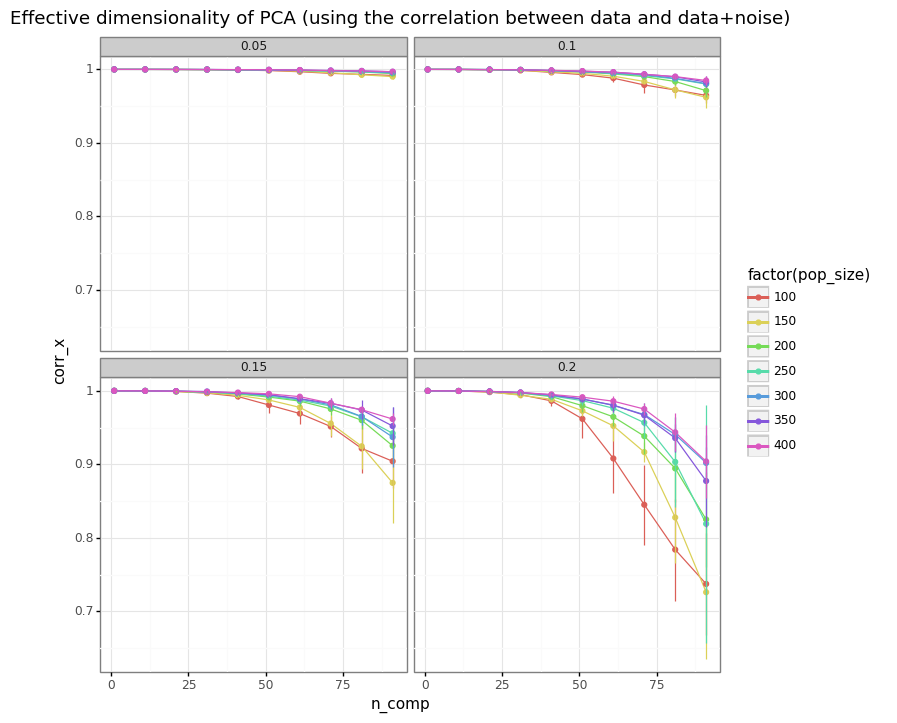

<ggplot: (8752993985021)>

In [95]:
fig = (
        ggplot(df, aes(x='n_comp', y='corr_x',colour='factor(pop_size)')) + 
        geom_line() +
        geom_point() + 
        geom_errorbar(aes(ymin='corr_x-corr_y', ymax='corr_x+corr_y'), width=.2,
                 position=position_dodge(0.05)) +
        theme_bw() + 
        theme(figure_size = (8, 8)) + 
        facet_wrap('~sigma_gaussian', ncol = 2) + 
        ggtitle('Effective dimensionality of PCA (using the correlation between data and data+noise)'))
fig

Each data point represents the correlation between the data and data+noise (blood log ratios) with respect of the number of components to compute the PCA. Each point represents the mean value over the 10 iterations of repeating the experiment. The data is subsampled ($[100,400]$ individuals). Each plot is wrapped by the sigma (standard deviation) of the gaussian distribution of the noise.